Loading dataset...
Combined dataset shape: (3672151, 7)

Preprocessing...

Class distribution:
Label
Normal    3372743
Attack     299408
Name: count, dtype: int64

Training CNN model...
Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17214/17214 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9455 - loss: 0.1506 - val_accuracy: 0.9609 - val_loss: 0.1129
Epoch 2/50
17214/17214 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9550 - loss: 0.1235 - val_accuracy: 0.9618 - val_loss: 0.1085
Epoch 3/50
17214/17214 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.9563 - loss: 0.1203 - val_accuracy: 0.9621 - val_loss: 0.1071
Epoch 4/50
17214/17214 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.9568 - loss: 0.1187 - val_accuracy: 0.9249 - val_loss: 0.1540
Epoch 5/50
17214/17214 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9578 - loss: 0.1171 - val_accuracy: 0.9623 - val_loss: 0.1065
Epoch 6/50
17214/17214 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.9584 - loss: 0.1153 - val_accuracy: 0.9628 - val_loss: 0.1050
Epoch 7/50
17214/17214 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.9584 - loss: 0.1151 - val_accuracy: 0.9623 - val_loss: 0.1055
Epoch 8/50
17214/17214 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.9587 - lo

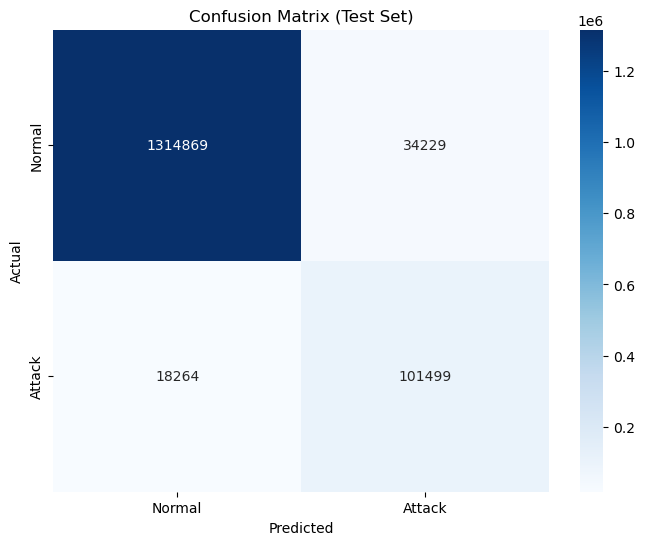

45902/45902 ━━━━━━━━━━━━━━━━━━━━ 16s 348us/step


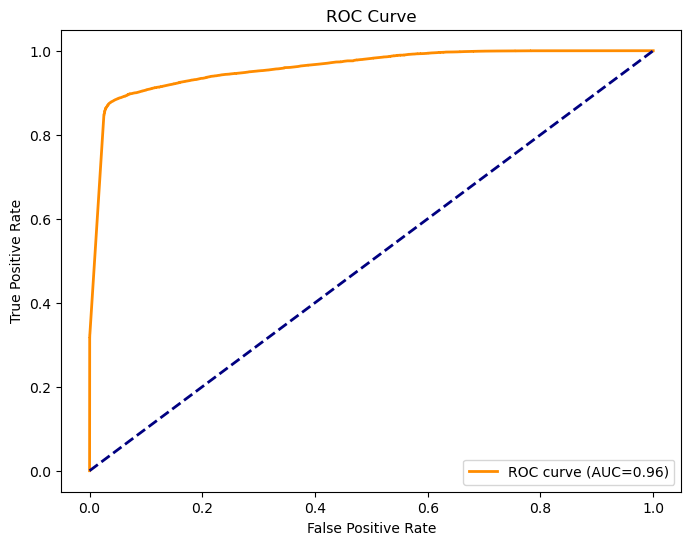

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

# Step 1: Define dataset directory
directory = "/Users/bodapati/Downloads/Car_Hacking_Challenge_Dataset_rev20Mar2021/0_Preliminary/0_Training"

# Step 2: Load and merge CSV files
def load_and_merge_files(dir_path):
    all_dfs = []
    for filename in os.listdir(dir_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(dir_path, filename)
            try:
                df = pd.read_csv(file_path)
                df['File'] = filename  
                all_dfs.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    if not all_dfs:
        raise ValueError("No CSV files found or all files failed to load.")
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined dataset shape: {combined_df.shape}")
    return combined_df

# Step 3: Preprocess the data
def preprocess_data(df):
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    
    num_cols = ['Timestamp', 'DLC']
    df[num_cols] = imputer_num.fit_transform(df[num_cols])
    
    cat_cols = ['Arbitration_ID', 'Data', 'Class', 'SubClass']
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
    
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Parse Data into 8 bytes
    def parse_data(data_str):
        try:
            bytes_list = data_str.strip().split()
            bytes_int = [int(b, 16) if b else 0 for b in bytes_list]
            while len(bytes_int) < 8:
                bytes_int.append(0)
            return bytes_int[:8]  
        except:
            return [0] * 8 
        
    data_bytes = df['Data'].apply(parse_data)
    data_bytes_df = pd.DataFrame(data_bytes.tolist(), columns=[f'Byte_{i+1}' for i in range(8)], index=df.index)
    df = pd.concat([df, data_bytes_df], axis=1)
    df.drop('Data', axis=1, inplace=True)
    
    # Feature engineering: time difference
    df.sort_values('Timestamp', inplace=True)
    df['Time_Diff'] = df['Timestamp'].diff().fillna(0)
    
    # Encode Arbitration_ID
    le_arb = LabelEncoder()
    df['Arbitration_ID_Encoded'] = le_arb.fit_transform(df['Arbitration_ID'])
    
    # Label: Normal = 0, Attack = 1
    df['Label'] = df['Class'].apply(lambda x: 0 if x.lower() == 'normal' else 1)
    
    df.drop(['Timestamp', 'Arbitration_ID', 'Class', 'SubClass', 'File'], axis=1, inplace=True)
    return df

# Step 4: Build CNN model
def build_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))  # 2 classes: Normal & Attack
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 5: Train and evaluate
def train_and_evaluate(X, y):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Reshape for CNN (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # One-hot encode labels
    y_train_cat = to_categorical(y_train, num_classes=2)
    y_test_cat = to_categorical(y_test, num_classes=2)
    
    # Build CNN
    model = build_cnn((X_train.shape[1], 1))
    
    # Train
    history = model.fit(X_train, y_train_cat, 
                        validation_data=(X_test, y_test_cat), 
                        epochs=50, batch_size=128, verbose=1)
    
    # Evaluate
    y_test_pred = np.argmax(model.predict(X_test), axis=1)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Attack']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()
    
    # ROC Curve
    y_test_prob = model.predict(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return model, history

# Main
if __name__ == "__main__":
    print("Loading dataset...")
    df = load_and_merge_files(directory)
    
    print("\nPreprocessing...")
    df_processed = preprocess_data(df)
    
    print("\nClass distribution:")
    print(df_processed['Label'].value_counts().rename({0:'Normal', 1:'Attack'}))
    
    X = df_processed.drop('Label', axis=1).values
    y = df_processed['Label'].values
    
    print("\nTraining CNN model...")
    cnn_model, history = train_and_evaluate(X, y)